# Одномерная генеративно-состязательная нейронная сеть

https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/    
#### Упрощенный пример, показывающий, что дискриминатор - это обычная модель нейронной сети.

Скопировано и переведено из репозитория
https://github.com/apple2373/chainer-GAN-1D

In [1]:
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils.vis_utils import plot_model
import numpy as np
from matplotlib import pyplot

Using TensorFlow backend.


In [4]:
# Создание n реальных образцов с метками классов
def generate_real_samples(n=100):
    # Создадим входы в пространстве [-0.5, 0.5]
    X1 = np.random.rand(n) - 0.5
    # Создадим выходы X^2
    X2 = X1 * X1
    # Соберем массивы
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = np.hstack((X1, X2))
    # Создадим клас меток
    y = np.ones((n, 1))
    return X, y

Первый шаг - Создадим новые точки в скрытом пространстве как входные данные для генератора. 
Этого можно добиться, вызвав NumPy функцию
randn () для генерации массивов случайных чисел, взятых из стандартного распределения гаусса.

In [5]:
def generate_latent_points(latent_dim, n):
    # Создадим точки в скрытом пространстве
    x_input = np.random.randn(latent_dim * n)
    # Преобразуем в пакет входов для сети
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [6]:
# Используем генератор, чтобы сгенерировать n поддельных примеров и построить результирующий график
def generate_fake_samples(generator, latent_dim, n):
    # Создадим точки в скрытом пространстве
    x_input = generate_latent_points(latent_dim, n)
    # Спрогнозируем выходы
    X = generator.predict(x_input)
    # Создадим клас меток
    y = np.zeros((n, 1))
    return X, y

Модель генератора принимает на вход точку из скрытого пространства и генерирует новую выборку,
например вектор с входными и выходными элементами нашей функции, например х и х ^ 2.    
Скрытая переменная - это скрытая или ненаблюдаемая переменная. А скрытое пространство - это многомерная
векторное пространство этих переменных. Мы можем определить размер скрытого пространства для нашей задачи,
а так же форму или распределение переменных в скрытом пространстве.    
Это связано с тем, что скрытое пространство не имеет значения, пока модель генератора не начнет присваивать
значительные точки в пространстве по мере обучения. После тренировки точки в скрытом пространстве будут
соответствовать точкам в пространстве вывода, например в пространстве сгенерированных образцов.    
Мы будем генерировать новые входные данные, выбирая случайные числа из стандартного распределения Гаусса,
т.е. среднее значение нуля и стандартное отклонение единицы.    
Входы: точка в скрытом пространстве, например пятиэлементный вектор гауссовских случайных чисел.    
Выходы: двухэлементный вектор, представляющий сгенерированный образец для нашей функции (x и x ^ 2).    
Модель не скомпилирована. Причина этого в том, что модель генератора не подходит напрямую.

In [7]:
# Определим модель автономного генератора
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

Модель должна взять образец из нашей задачи, например вектор с двумя элементами, и вывести предсказание классификации относительно того, является ли образец настоящим или поддельным.
Входные данные: образец с двумя действительными значениями.  
Выходы: двоичная классификация, вероятность того, что образец настоящий (или поддельный).

In [8]:
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation="relu", kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

Веса в модели генератора обновляются в зависимости от производительности модели дискриминатора.   
Когда дискриминатор хорошо обнаруживает поддельные образцы, генератор обновляется сильнее, а
когда модель дискриминатора относительно плохая или запутанная при обнаружении поддельных образцов,
модель генератора обновляется слабее.   
Это определяет отношения с нулевой суммой или противоборство между этими двумя моделями.   
Можно найти много способов реализовать это с помощью API Keras, но, пожалуй, самый простой
подход заключается в создании новой модели, которая включает или инкапсулирует генератор и
модели дискриминатора.   
В частности, можно определить новую модель GAN, которая объединяет генератор и дискриминатор
так, что генератор получает на вход случайные точки в скрытом пространстве, генерирует
выборки, которые напрямую передаются в модель дискриминатора, классифицируются,
и затем выходные данные этой более крупной модели могут использоваться для обновления весов модели генератора.
Только дискриминатор занимается различением реальных и поддельных примеров.   
Модель генератора следит только за производительностью дискриминатора на поддельных примерах.   
Поэтому мы отметим все слои в дискриминаторе как не обучаемые, в той
части модели GAN, которую не следует обновлять и тренировать на поддельных примерах.   
При обучении генератора с помощью этой включенной модели GAN есть еще одно важное изменение.   
Мы хотим, чтобы дискриминатор считал выборки, выдаваемые генератором, настоящими, а не фальшивыми.   
Поэтому, когда генератор обучается как часть модели GAN, мы будем отмечать сгенерированные
образцы как настоящие (класс 1).   
Модель дискриминатора была помечена как не обучаемая, добавлена в модель GAN и скомпилирована.   
В этой модели веса модели дискриминатора не обучаются и не могут быть изменены, когда модель GAN 
обновляется с помощью вызовов train_on_batch ().   
Входы: точка в скрытом пространстве, например пятиэлементный вектор гауссовских случайных чисел.   
Выходы: двоичная классификация, вероятность того, что образец настоящий (или поддельный).

In [9]:
# Определим комбинированную модель генератора и дискриминатора для обновления генератора
def define_gan(generator, discriminator):
    # Сделаем веса в дискриминаторе не обучаемыми
    discriminator.trainable = False
    # Соединим их
    model = Sequential()
    # И генератор
    model.add(generator)
    # Добавим дискриминатор
    model.add(discriminator)
    # Скомпилируем модель
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [10]:
# Оценим дискриминатор, построим реальные и ложные точки
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # Подготовка реальных примеров
    x_real, y_real = generate_real_samples(n)
    # Оценка дискриминатора на реальных примерах
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # Подготовка поддельных примеров
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # Оценка дискриминатора на поддельных примерах
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # Итог производительности дискриминатора
    print(epoch, acc_real, acc_fake)
    # График поддельных и реальных точек
    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    pyplot.show()

In [11]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
    # Определим половину размера одного пакета, для обновления дискриминатора
    half_batch = int(n_batch / 2)
    # Обходим эпохи
    for i in range(n_epochs):
        # Подготовка реальных примеров
        x_real, y_real = generate_real_samples(half_batch)
        # Подготовка поддельных примеров
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # Обновление дискриминатора
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # Подготовка точек в скрытом пространстве, в качестве входных данных для генератора
        x_gan = generate_latent_points(latent_dim, n_batch)
        # Создадим перевернутые метки для поддельных образцов
        y_gan = np.ones((n_batch, 1))
        # Обновим генератор, используя ошибку дискриминатора
        gan_model.train_on_batch(x_gan, y_gan)
        # Оценим модель, на каждой из n_eval эпох
        if (i + 1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

In [12]:
latent_dim = 5
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan = define_gan(generator, discriminator)

1999 0.30000001192092896 0.7599999904632568


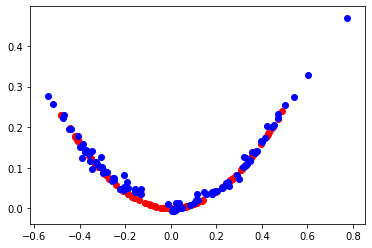

3999 0.6299999952316284 0.41999998688697815


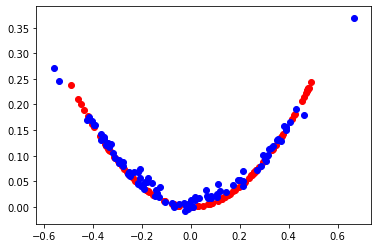

5999 0.7799999713897705 0.4699999988079071


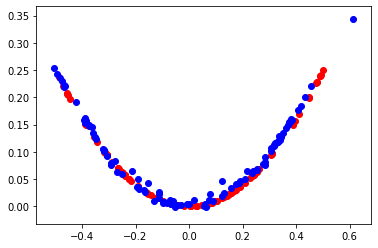

7999 0.5600000023841858 0.5600000023841858


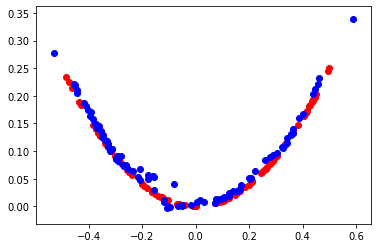

9999 0.5799999833106995 0.5400000214576721


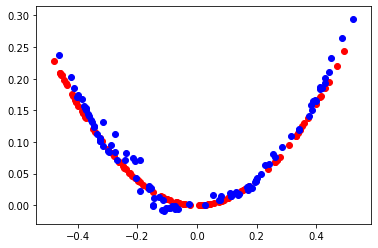

In [13]:
#plot_model(discriminator, to_file="discriminator.png", show_shapes=True)
#plot_model(generator, to_file="generator.png", show_shapes=True)
#plot_model(gan, to_file="gan.png", show_shapes=True)
train(generator, discriminator, gan, latent_dim)